<a href="https://colab.research.google.com/github/pragmatic-philosopher09/Audio-Emotion-Analyzer-Through-Deep-Learning/blob/main/Transformer_Big_Model_%5BBiLSTM_%2B_Encoder_%2B_Decoder_%2B_Scaled_Dot_Product_Attention%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import keras
#from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Features = pd.read_csv('/content/drive/MyDrive/features_dataset.csv')
Features.head()
# Features.shape

Mounted at /content/drive


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,152,153,154,155,156,157,158,159,160,labels
0,0,0.272267,0.689451,0.708028,0.666473,0.715468,0.694820,0.627661,0.632560,0.687715,...,0.000687,0.000502,0.000372,0.000197,0.000137,0.000288,0.000349,0.000143,1.498768e-05,angry
1,1,0.262035,0.603476,0.668302,0.692199,0.709884,0.658301,0.605176,0.609343,0.640842,...,0.000009,0.000012,0.000028,0.000034,0.000036,0.000035,0.000032,0.000011,8.432723e-07,calm
2,2,0.195466,0.628032,0.687169,0.651985,0.621273,0.604192,0.640623,0.626136,0.652430,...,0.000086,0.000107,0.000061,0.000052,0.000059,0.000095,0.000090,0.000031,2.326331e-06,sad
3,3,0.173769,0.720864,0.685492,0.655122,0.652557,0.587786,0.550012,0.638170,0.707171,...,0.000064,0.000051,0.000074,0.000129,0.000198,0.000243,0.000190,0.000074,4.691918e-06,fear
4,4,0.207284,0.692981,0.737456,0.726056,0.685032,0.636497,0.568223,0.528898,0.598124,...,0.000018,0.000014,0.000014,0.000005,0.000007,0.000011,0.000016,0.000008,4.218449e-07,sad


In [ ]:
from sklearn.utils import shuffle
temp = shuffle(Features)
# temp[:10]


df = np.random.rand(len(temp)) < 0.8
train = temp[df]
test = temp[~df] # 1 - train basically


trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]


from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)


In [ ]:
print('Train dimension:')
print(x_train.shape)
print('Test dimension:')
print(x_test.shape)

print('Train labels dimension:')
print(y_train.shape)
print('Test labels dimension:')
print(y_test.shape)

Train dimension:
(1173, 162, 1)
Test dimension:
(267, 162, 1)
Train labels dimension:
(1173, 8)
Test labels dimension:
(267, 8)


In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Dense, Dot, Activation, Concatenate,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# define input shape
inputs = Input(shape=(x_train.shape[1], 1))

# add BiLSTM layer
encoder = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)))(inputs)

# attention mechanism
attention_scores = Dot(axes=[2, 2])([encoder, encoder])
attention_scores = Softmax()(attention_scores)
attention_context = Dot(axes=[2, 1])([attention_scores, encoder])

# add output layer
outputs = Dense(8, activation='softmax')(Flatten()(Bidirectional(LSTM(64, return_sequences=True))(Concatenate(axis=2)([attention_context, encoder]))))

# create model
model = Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# print model summary
model.summary()

# train the model
history=model.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test), shuffle=True)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 162, 1)]     0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 162, 512)    528384      ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 dot_6 (Dot)                    (None, 162, 162)     0           ['bidirectional_6[0][0]',        
                                                                  'bidirectional_6[0][0]']        
                                                                                            

9/9 [==============================] - 0s 34ms/step - loss: 1.5344 - accuracy: 0.6554
Accuracy of our model on test data :  65.54307341575623 %


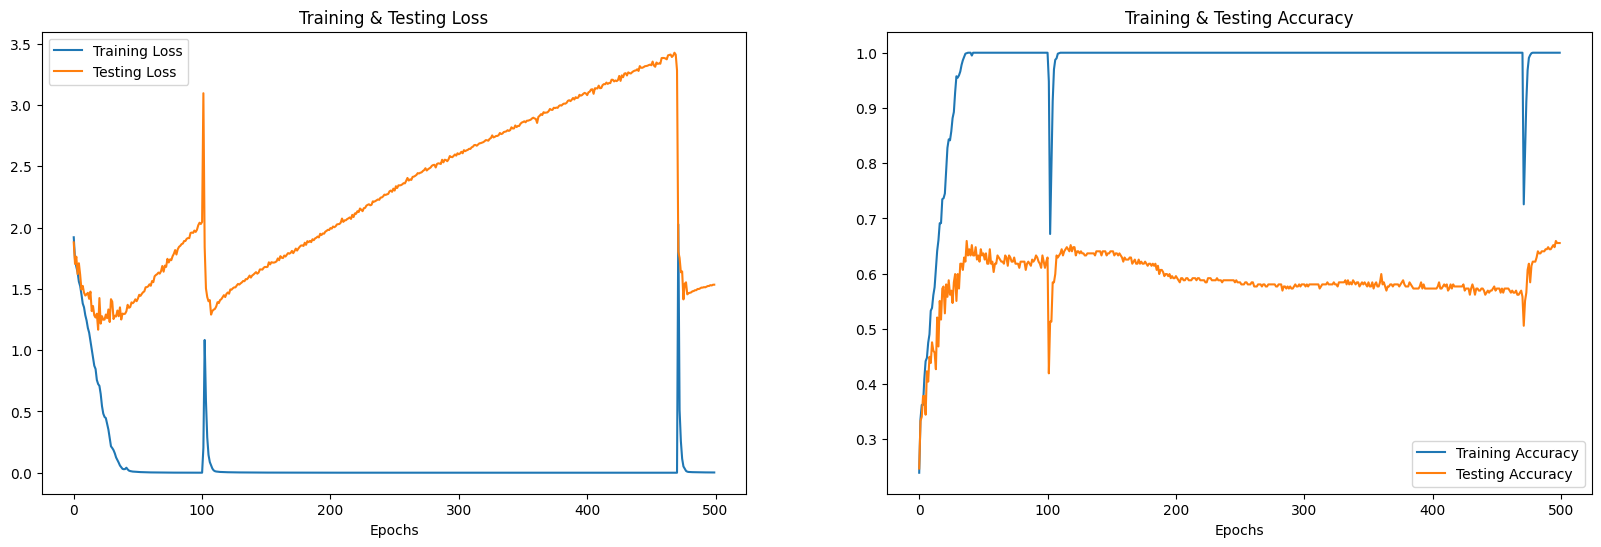

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(500)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

<Axes: >

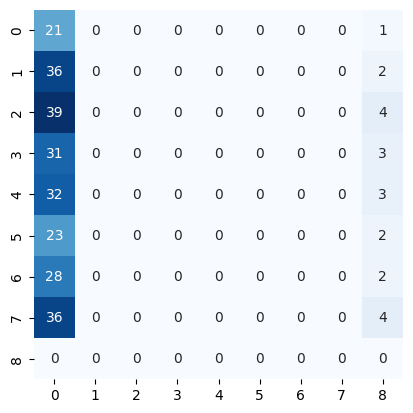

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert y_test to one-dimensional array of label indices
y_test_indices = np.argmax(y_test, axis=1)

# Convert x_test_cnn to one-dimensional array of label indices
x_test_indices = np.argmax(x_test, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test_indices, x_test_indices)

# Visualize confusion matrix as heatmap
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

9/9 [==============================] - 4s 29ms/step


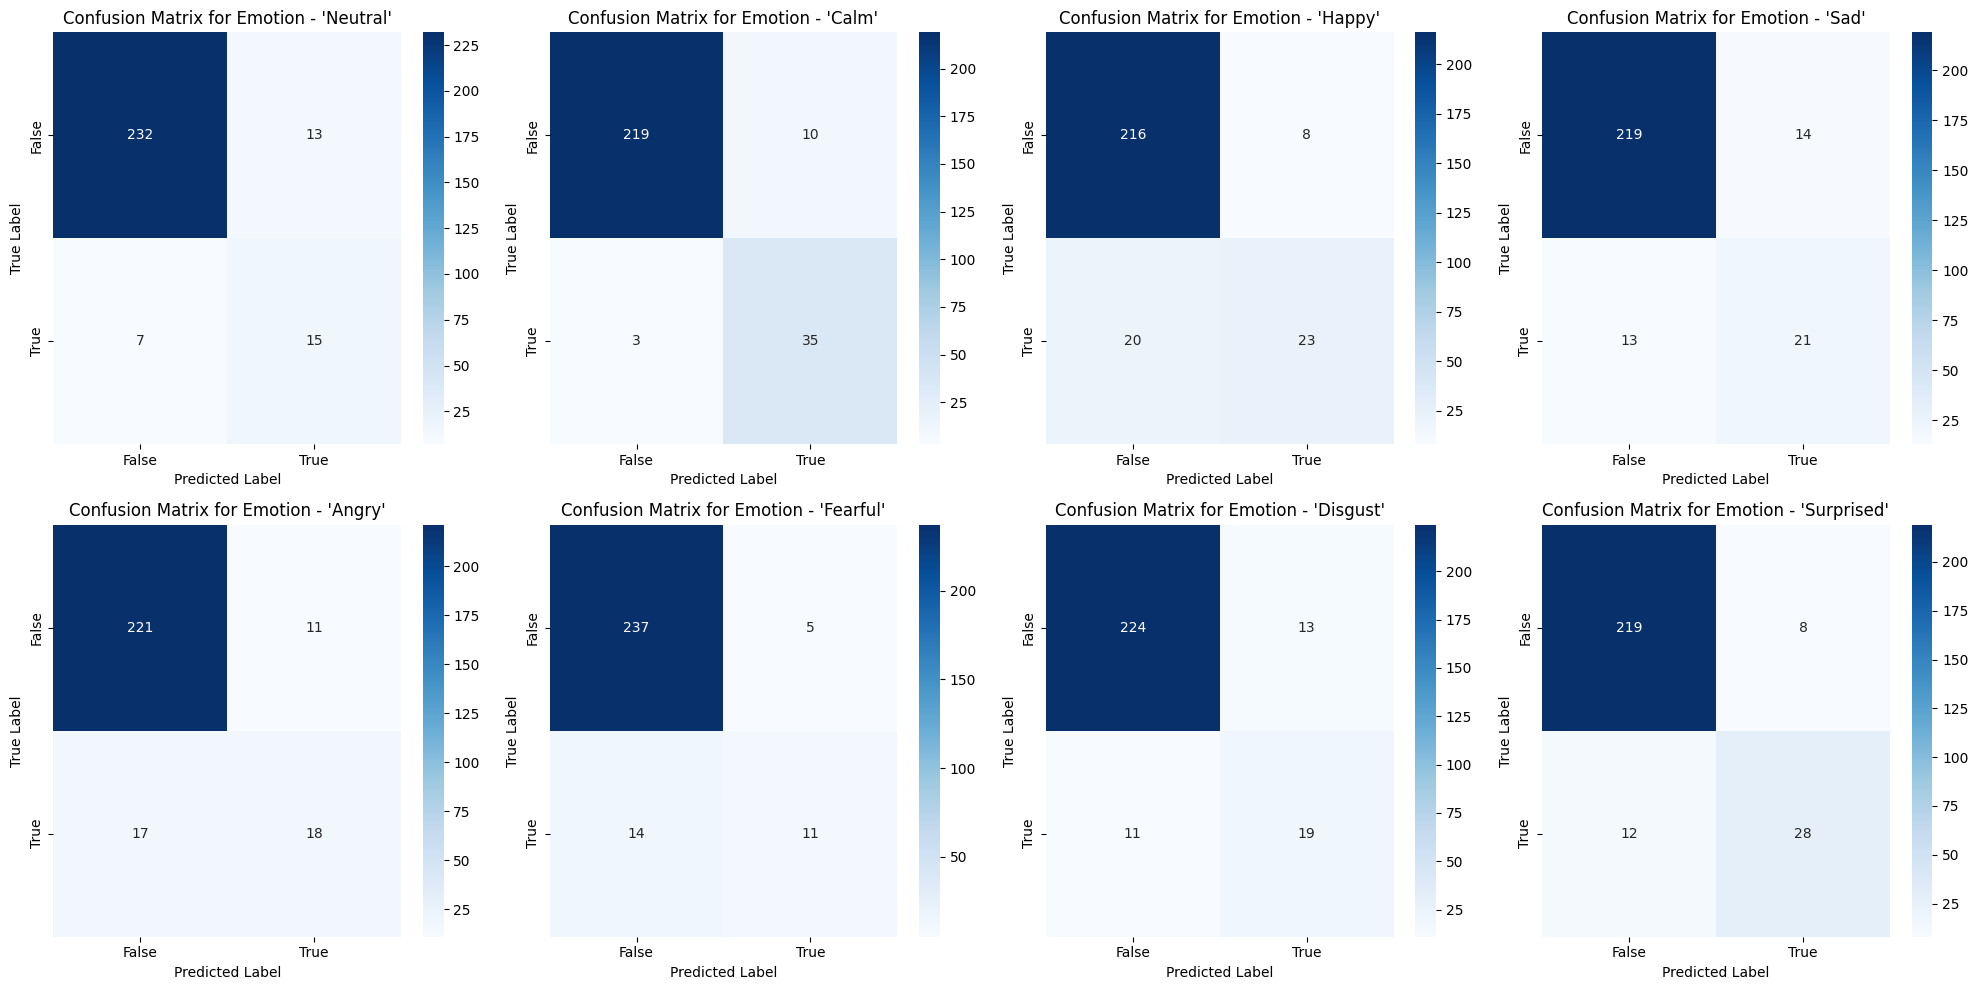

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report

y_pred = model.predict(x_test)

# Convert the predictions and ground truth labels to binary matrices
y_pred_bin = (y_pred > 0.5).astype(int)
y_test_bin = y_test.astype(int)

# Calculate the confusion matrix
conf_mat = multilabel_confusion_matrix(y_test_bin, y_pred_bin)

# Define the class names
class_names = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

# Plot the confusion matrix for each class
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sns.heatmap(conf_mat[i], annot=True, cmap="Blues", fmt="d", xticklabels=["False", "True"], yticklabels=["False", "True"], ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title(f"Confusion Matrix for Emotion - '{class_names[i]}'")
    axs[i//4, i%4].set_xlabel("Predicted Label")
    axs[i//4, i%4].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.54      0.68      0.60        22
           1       0.78      0.92      0.84        38
           2       0.74      0.53      0.62        43
           3       0.60      0.62      0.61        34
           4       0.62      0.51      0.56        35
           5       0.69      0.44      0.54        25
           6       0.59      0.63      0.61        30
           7       0.78      0.70      0.74        40

   micro avg       0.67      0.64      0.66       267
   macro avg       0.67      0.63      0.64       267
weighted avg       0.68      0.64      0.65       267
 samples avg       0.64      0.64      0.64       267



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import recall_score

# make predictions on the test data
y_pred = model.predict(x_test)

# convert the predictions and true labels to binary format
y_pred_bin = np.argmax(y_pred, axis=1)
y_true_bin = np.argmax(y_test, axis=1)

# calculate recall
recall = recall_score(y_true_bin, y_pred_bin, average='macro')

print('Recall: ', recall)


9/9 [==============================] - 0s 28ms/step
Recall:  0.6483755932549942


9/9 [==============================] - 0s 28ms/step


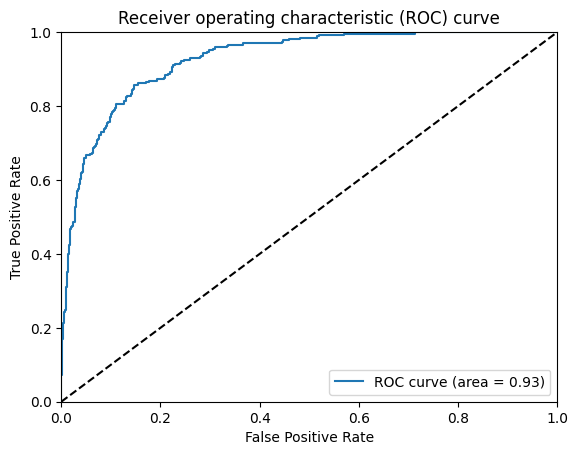

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(x_test)
# calculate false positive rate, true positive rate, and threshold values for ROC curve
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate AUC score
auc_score = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# predict classes for test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


# compute F1 score
f1score = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("F1 score:", f1score)


9/9 [==============================] - 0s 30ms/step
F1 score: 0.6524674064626625


In [ ]:
from sklearn.metrics import recall_score

# compute sensitivity
sensitivity = recall_score(y_test_classes, y_pred_classes,average='weighted')

print("Sensitivity:", sensitivity)


Sensitivity: 0.6554307116104869


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_true=y_test_classes, y_pred=y_pred_classes, average='weighted')
print("Precision:", precision)


Precision: 0.6660399334454514
